In [1]:
# Importing necessary packages

import keras

from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
from sklearn.linear_model import Ridge
import os
import pandas as pd
from sklearn.metrics import *
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from collections import defaultdict as dd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from slir import SparseLinearRegression

import operator
import re
from collections import Counter

from IPython.display import HTML, display
from IPython.display import Image

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib  

import pickle

from utils import detector_utils as detector_utils
import cv2
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras import losses

C:\Users\Theodora\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Using matplotlib backend: Qt4Agg


In [2]:
# The 10 possible gesture labels (and other global variables, irrelevant stuff etc etc)

gestures = {
    1:"fist",
    2:"index",
    3:"pinky",
    4:"l",
    5:"two",
    6:"three",
    7:"ronaldinho",
    8:"metal",
    9:"palm",
    10:"jesus"
}

In [3]:
# Preprocessing the image

# Cropping the hand from the whole image

def detect_hand(path):
    image_np = cv2.imread(path)
    (h, w, d) = image_np.shape
    im_width, im_height = w, h

    try:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    except:
        print("Error converting to RGB")

    # Actual detection. Variable boxes contains the bounding box cordinates for hands detected,
    # while scores contains the confidence for each of these boxes.
    # Hint: If len(boxes) > 1 , you may assume you have found atleast one hand (within your score threshold)
    boxes, scores = detector_utils.detect_objects(image_np,
                                                    detection_graph, sess)

    
    hand = detector_utils.get_roi(num_hands_detect, 0.2, scores, boxes, im_width, im_height,image_np)

    try:
       return hand
    except:
        print("No hands")
        return None

In [4]:
"""
# Uncomment this only if desired to crop hands automatically.
# Not advised.
# Directory with original images
picture_dir = ".\\poses_kinect"

# Directory with cropped hands
destination_dir = ".\\automatically_cropped"
os.mkdir(destination_dir)

# max number of hands we want to detect/track
num_hands_detect = 2

#Load the pretrained model
# os.chdir("..")
detection_graph, sess = detector_utils.load_inference_graph()

# For each gesture, we create its subfolder
for g in gestures:
    dir_name = destination_dir + "\\" + gestures[g]
    os.mkdir(dir_name)

# Changing the current directory to the directory of cropped hands
# os.chdir(picture_dir)

number = 0
for (dirpath, dirnames, filenames) in os.walk(picture_dir):
    for filename in filenames:
        path = os.path.join(dirpath, filename)
        gesture = os.path.basename(os.path.dirname(path)) 
        hand = detect_hand(path)
        if hand is not None:
            dest_path = destination_dir + "\\" + gesture + "\\" + str(number) + ".jpg"
            cv2.imwrite(dest_path, cv2.cvtColor(hand, cv2.COLOR_RGB2BGR))
            number += 1
"""      
# Removing background

'\n# Uncomment this only if desired to crop hands automatically.\n# Not advised.\n# Directory with original images\npicture_dir = ".\\poses_kinect"\n\n# Directory with cropped hands\ndestination_dir = ".\\automatically_cropped"\nos.mkdir(destination_dir)\n\n# max number of hands we want to detect/track\nnum_hands_detect = 2\n\n#Load the pretrained model\n# os.chdir("..")\ndetection_graph, sess = detector_utils.load_inference_graph()\n\n# For each gesture, we create its subfolder\nfor g in gestures:\n    dir_name = destination_dir + "\\" + gestures[g]\n    os.mkdir(dir_name)\n\n# Changing the current directory to the directory of cropped hands\n# os.chdir(picture_dir)\n\nnumber = 0\nfor (dirpath, dirnames, filenames) in os.walk(picture_dir):\n    for filename in filenames:\n        path = os.path.join(dirpath, filename)\n        gesture = os.path.basename(os.path.dirname(path)) \n        hand = detect_hand(path)\n        if hand is not None:\n            dest_path = destination_dir + "\

In [5]:
# Visual-features-only : Experiment one, CNN from Scratch

In [6]:
# Visual-features-only : Experiment two, transfer learning, using VGG19

# os.chdir("..")
# print(os.getcwd())
# Transfer learning with VGG19
base_model=VGG19(weights='imagenet',include_top=False, input_shape = (128, 128, 3)) #imports the VGG19 model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Adding dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(512,activation='relu')(x)

# Dense layer 2
x = Dense(512,activation='relu')(x) 

# Dense layer 3
x = Dense(512,activation='relu')(x) 
preds = Dense(10,activation='softmax')(x) #final layer with softmax activation

# Load the previously created model
model=Model(inputs=base_model.input,outputs=preds)

# TODO : what does this do ?

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True
    
# Prepare the data for training
batch_size = 32
validation_split = 0.2
epochs = 1 # WILL PUT 100 AFTER TESTING ALL CODE

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=validation_split)

print(os.getcwd())
train_generator = train_datagen.flow_from_directory(
    '.\\poses',
    target_size=(128,128),
     color_mode='rgb',
     batch_size=batch_size,
     class_mode='categorical',
     subset = 'training') # set as training data


validation_generator = train_datagen.flow_from_directory(
    '.\\poses',
    target_size=(128,128),
     color_mode='rgb',
     batch_size=batch_size,
     class_mode='categorical',
     subset = 'validation') # set as validation data


step_size_train=train_generator.n//train_generator.batch_size

Instructions for updating:
Colocations handled automatically by placer.
D:\FINAL_PROJECT_PI4
Found 559 images belonging to 10 classes.
Found 133 images belonging to 10 classes.


In [7]:
# Compiling and fitting the model and getting results
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
17/17 [==============================] - 251s 15s/step - loss: 2.1215 - acc: 0.2390 - val_loss: 1.6852 - val_acc: 0.4141


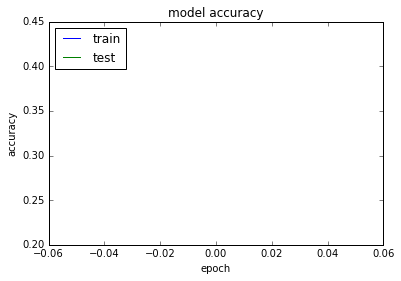

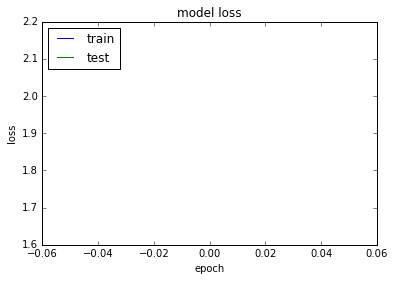

In [8]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# General function to create a dataframe with columns [pose, camera_angle, f1, ..., f1000]
def create_df():
    df = pd.DataFrame(columns=["pose", "camera_angle"])
    for i in range(1, 1001):
        df['f'+str(i)] = -1
    return df

In [17]:
# Putting the visual featurers of the real hands into a csv
df = create_df()
print(os.getcwd())

model = VGG19(weights='imagenet',include_top=False, input_shape = (128, 128, 3))

processed_files = 0
# load and preprocess image

path, dirs, files = next(os.walk(os.getcwd() + "/poses")) # or "/hand_poses" if cropped automatically
print(path)
print(dirs)
print(files)

for directory in dirs:
    subdir_path = path + "/" + directory
    p, d, files = next(os.walk(subdir_path))
    print(files)
    
    for file in files:
    
        img_path = subdir_path  + "/" + file
        print(img_path)
        img = image.load_img(img_path, target_size=(128, 128))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        for id_gesture, g in gestures.items():
            if g == directory:
                print(g)
                pose = g

                # predict the class probabilities - extracting the visual features
                preds = model.predict(x)
                p = preds.flatten()

                data = np.insert(p, 0, id_gesture)
                data = np.insert(data, 1, 0)
        
        
                print(df.shape)
                df.loc[len(df)] = data[1:1003]
                df["camera_angle"] = "straight_on"

                print(processed_files)
                processed_files += 1

print(str(processed_files) + " processed files")
print(df.shape)
print(df)

df.to_csv(os.getcwd() + "/data/real-hands.csv")



D:\FINAL_PROJECT_PI4
D:\FINAL_PROJECT_PI4/poses
['fist', 'index', 'jesus', 'l', 'metal', 'palm', 'pinky', 'ronaldinho', 'three', 'two']
[]
['0.jpg', '1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '4.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '5.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '6.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '7.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '8.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg',

(111, 1002)
111
D:\FINAL_PROJECT_PI4/poses/index/119.jpg
index
(112, 1002)
112
D:\FINAL_PROJECT_PI4/poses/index/120.jpg
index
(113, 1002)
113
D:\FINAL_PROJECT_PI4/poses/index/121.jpg
index
(114, 1002)
114
D:\FINAL_PROJECT_PI4/poses/index/122.jpg
index
(115, 1002)
115
D:\FINAL_PROJECT_PI4/poses/index/123.jpg
index
(116, 1002)
116
D:\FINAL_PROJECT_PI4/poses/index/124.jpg
index
(117, 1002)
117
D:\FINAL_PROJECT_PI4/poses/index/125.jpg
index
(118, 1002)
118
D:\FINAL_PROJECT_PI4/poses/index/126.jpg
index
(119, 1002)
119
D:\FINAL_PROJECT_PI4/poses/index/127.jpg
index
(120, 1002)
120
D:\FINAL_PROJECT_PI4/poses/index/128.jpg
index
(121, 1002)
121
D:\FINAL_PROJECT_PI4/poses/index/129.jpg
index
(122, 1002)
122
D:\FINAL_PROJECT_PI4/poses/index/130.jpg
index
(123, 1002)
123
D:\FINAL_PROJECT_PI4/poses/index/131.jpg
index
(124, 1002)
124
D:\FINAL_PROJECT_PI4/poses/index/132.jpg
index
(125, 1002)
125
D:\FINAL_PROJECT_PI4/poses/index/133.jpg
index
(126, 1002)
126
D:\FINAL_PROJECT_PI4/poses/index/134.jp

(224, 1002)
224
D:\FINAL_PROJECT_PI4/poses/l/225.jpg
l
(225, 1002)
225
D:\FINAL_PROJECT_PI4/poses/l/226.jpg
l
(226, 1002)
226
D:\FINAL_PROJECT_PI4/poses/l/227.jpg
l
(227, 1002)
227
D:\FINAL_PROJECT_PI4/poses/l/228.jpg
l
(228, 1002)
228
D:\FINAL_PROJECT_PI4/poses/l/229.jpg
l
(229, 1002)
229
D:\FINAL_PROJECT_PI4/poses/l/230.jpg
l
(230, 1002)
230
D:\FINAL_PROJECT_PI4/poses/l/231.jpg
l
(231, 1002)
231
D:\FINAL_PROJECT_PI4/poses/l/232.jpg
l
(232, 1002)
232
D:\FINAL_PROJECT_PI4/poses/l/233.jpg
l
(233, 1002)
233
D:\FINAL_PROJECT_PI4/poses/l/234.jpg
l
(234, 1002)
234
D:\FINAL_PROJECT_PI4/poses/l/235.jpg
l
(235, 1002)
235
D:\FINAL_PROJECT_PI4/poses/l/236.jpg
l
(236, 1002)
236
D:\FINAL_PROJECT_PI4/poses/l/237.jpg
l
(237, 1002)
237
D:\FINAL_PROJECT_PI4/poses/l/238.jpg
l
(238, 1002)
238
D:\FINAL_PROJECT_PI4/poses/l/239.jpg
l
(239, 1002)
239
D:\FINAL_PROJECT_PI4/poses/l/240.jpg
l
(240, 1002)
240
D:\FINAL_PROJECT_PI4/poses/l/241.jpg
l
(241, 1002)
241
D:\FINAL_PROJECT_PI4/poses/l/242.jpg
l
(242, 1002

(341, 1002)
341
D:\FINAL_PROJECT_PI4/poses/palm/342.jpg
palm
(342, 1002)
342
D:\FINAL_PROJECT_PI4/poses/palm/343.jpg
palm
(343, 1002)
343
D:\FINAL_PROJECT_PI4/poses/palm/344.jpg
palm
(344, 1002)
344
D:\FINAL_PROJECT_PI4/poses/palm/345.jpg
palm
(345, 1002)
345
D:\FINAL_PROJECT_PI4/poses/palm/346.jpg
palm
(346, 1002)
346
D:\FINAL_PROJECT_PI4/poses/palm/347.jpg
palm
(347, 1002)
347
D:\FINAL_PROJECT_PI4/poses/palm/348.jpg
palm
(348, 1002)
348
D:\FINAL_PROJECT_PI4/poses/palm/349.jpg
palm
(349, 1002)
349
D:\FINAL_PROJECT_PI4/poses/palm/350.jpg
palm
(350, 1002)
350
D:\FINAL_PROJECT_PI4/poses/palm/351.jpg
palm
(351, 1002)
351
D:\FINAL_PROJECT_PI4/poses/palm/352.jpg
palm
(352, 1002)
352
D:\FINAL_PROJECT_PI4/poses/palm/353.jpg
palm
(353, 1002)
353
D:\FINAL_PROJECT_PI4/poses/palm/354.jpg
palm
(354, 1002)
354
D:\FINAL_PROJECT_PI4/poses/palm/355.jpg
palm
(355, 1002)
355
D:\FINAL_PROJECT_PI4/poses/palm/356.jpg
palm
(356, 1002)
356
D:\FINAL_PROJECT_PI4/poses/palm/357.jpg
palm
(357, 1002)
357
D:\FINAL

(462, 1002)
462
D:\FINAL_PROJECT_PI4/poses/pinky/463.jpg
pinky
(463, 1002)
463
D:\FINAL_PROJECT_PI4/poses/pinky/464.jpg
pinky
(464, 1002)
464
D:\FINAL_PROJECT_PI4/poses/pinky/465.jpg
pinky
(465, 1002)
465
D:\FINAL_PROJECT_PI4/poses/pinky/466.jpg
pinky
(466, 1002)
466
D:\FINAL_PROJECT_PI4/poses/pinky/467.jpg
pinky
(467, 1002)
467
D:\FINAL_PROJECT_PI4/poses/pinky/468.jpg
pinky
(468, 1002)
468
D:\FINAL_PROJECT_PI4/poses/pinky/469.jpg
pinky
(469, 1002)
469
D:\FINAL_PROJECT_PI4/poses/pinky/470.jpg
pinky
(470, 1002)
470
D:\FINAL_PROJECT_PI4/poses/pinky/471.jpg
pinky
(471, 1002)
471
D:\FINAL_PROJECT_PI4/poses/pinky/472.jpg
pinky
(472, 1002)
472
D:\FINAL_PROJECT_PI4/poses/pinky/473.jpg
pinky
(473, 1002)
473
D:\FINAL_PROJECT_PI4/poses/pinky/474.jpg
pinky
(474, 1002)
474
D:\FINAL_PROJECT_PI4/poses/pinky/475.jpg
pinky
(475, 1002)
475
D:\FINAL_PROJECT_PI4/poses/pinky/476.jpg
pinky
(476, 1002)
476
D:\FINAL_PROJECT_PI4/poses/pinky/477.jpg
pinky
(477, 1002)
477
D:\FINAL_PROJECT_PI4/poses/pinky/478.jp

(570, 1002)
570
D:\FINAL_PROJECT_PI4/poses/ronaldinho/571.jpg
ronaldinho
(571, 1002)
571
D:\FINAL_PROJECT_PI4/poses/ronaldinho/572.jpg
ronaldinho
(572, 1002)
572
D:\FINAL_PROJECT_PI4/poses/ronaldinho/573.jpg
ronaldinho
(573, 1002)
573
D:\FINAL_PROJECT_PI4/poses/ronaldinho/574.jpg
ronaldinho
(574, 1002)
574
D:\FINAL_PROJECT_PI4/poses/ronaldinho/575.jpg
ronaldinho
(575, 1002)
575
D:\FINAL_PROJECT_PI4/poses/ronaldinho/576.jpg
ronaldinho
(576, 1002)
576
D:\FINAL_PROJECT_PI4/poses/ronaldinho/577.jpg
ronaldinho
(577, 1002)
577
D:\FINAL_PROJECT_PI4/poses/ronaldinho/578.jpg
ronaldinho
(578, 1002)
578
D:\FINAL_PROJECT_PI4/poses/ronaldinho/579.jpg
ronaldinho
(579, 1002)
579
D:\FINAL_PROJECT_PI4/poses/ronaldinho/580.jpg
ronaldinho
(580, 1002)
580
D:\FINAL_PROJECT_PI4/poses/ronaldinho/581.jpg
ronaldinho
(581, 1002)
581
D:\FINAL_PROJECT_PI4/poses/ronaldinho/582.jpg
ronaldinho
(582, 1002)
582
D:\FINAL_PROJECT_PI4/poses/ronaldinho/583.jpg
ronaldinho
(583, 1002)
583
D:\FINAL_PROJECT_PI4/poses/ronaldin

(683, 1002)
683
D:\FINAL_PROJECT_PI4/poses/two/684.jpg
two
(684, 1002)
684
D:\FINAL_PROJECT_PI4/poses/two/685.jpg
two
(685, 1002)
685
D:\FINAL_PROJECT_PI4/poses/two/686.jpg
two
(686, 1002)
686
D:\FINAL_PROJECT_PI4/poses/two/687.jpg
two
(687, 1002)
687
D:\FINAL_PROJECT_PI4/poses/two/688.jpg
two
(688, 1002)
688
D:\FINAL_PROJECT_PI4/poses/two/689.jpg
two
(689, 1002)
689
D:\FINAL_PROJECT_PI4/poses/two/690.jpg
two
(690, 1002)
690
D:\FINAL_PROJECT_PI4/poses/two/691.jpg
two
(691, 1002)
691
692 processed files
(692, 1002)
     pose camera_angle   f1        f2        f3        f4   f5        f6  \
0     0.0  straight_on  0.0  0.000000  0.000000  0.000000  0.0  0.593378   
1     0.0  straight_on  0.0  0.000000  0.000000  0.548773  0.0  0.010612   
2     0.0  straight_on  0.0  0.000000  0.000000  0.603401  0.0  0.020404   
3     0.0  straight_on  0.0  0.000000  0.000000  0.098741  0.0  0.000000   
4     0.0  straight_on  0.0  0.000000  0.000000  0.069987  0.0  0.000000   
5     0.0  straight_on  

In [ ]:
# Getting tendon activations : 
# Train the RRM using the screenshots csv and
# load the real_hands csv into the Ridge Regression Model

def read_raw_data():
    data = pd.read_csv('data/hand_data3_separated.csv',  index_col=False)

    # remove punctuation
    data['desc_list'] = data.description.apply(lambda x: [i for i in re.sub(r'[^\w\s]','',str(x)).lower().split()])
    data['desc_str'] = data.desc_list.apply(lambda x: ' '.join(x))

    #add one-hot encoding
    camera_data = pd.get_dummies(data.camera_angle)
    data = pd.concat([data, camera_data], axis=1)
    cols = data.columns.tolist()
    cols = cols[:8] + cols[-4:] + cols[8:-4]
    data = data[cols]
    
    #get words and vocabs
    words = [y for x in data.desc_list for y in x]
    vocab = list(set(words))
    print('number of unique words in our data:', len(vocab), '\nnumber of word tokens in our data: ', len(words))
    
    return data, words, vocab

def read_in_data():
    train_data = pd.read_pickle("data/train_data3_separated.pkl")
    test_data = pd.read_pickle("data/test_data3_separated.pkl")
    return train_data, test_data

def stack_training_data(mydata):
    s = mydata.apply(lambda x: pd.Series(x['desc_list']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'word'
    mydata = mydata.join(s)
    return mydata

def remove_unwated_words(mydata, vocab, words):
    wanted_words = list(set(words))
    unwanted_words = {'hand', 'and', 'the', 'a', 'with', 'is', 'are', 'to', 'of', 'finger', 'fingers', 'thumb'}
    unwanted_tags = {}
    for curr_word in vocab:
        if curr_word in unwanted_words:
            wanted_words.remove(curr_word)
    mydata = mydata.loc[mydata['word'].isin(wanted_words)]
    return mydata

_, words, vocab = read_raw_data()
train_data, test_data = read_in_data()
train_data[:10]

data, words, vocab = read_raw_data()

data.columns[:15]

START_COL = 'T1' 
END_COL = 'T5'
V_START_COL = 'f1'
V_END_COL = 'f1000'

y = train_data.ix[:,START_COL:END_COL].as_matrix()
X = train_data.ix[:,V_START_COL:V_END_COL].as_matrix()
y_test = test_data.ix[:,START_COL:END_COL].as_matrix()
X_test = test_data.ix[:,V_START_COL:V_END_COL].as_matrix()
y_all = data.ix[:,START_COL:END_COL].as_matrix()
X_all = data.ix[:,V_START_COL:V_END_COL].as_matrix()

print("train", X.shape, y.shape)
print("test", X_test.shape, y_test.shape)
print("all", X_all.shape, y_all.shape)


model = Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None, normalize=True, 
              random_state=False, solver='auto', tol=0.01)
model.fit(X, y)

In [ ]:
# Getting tendons for real hands
data = pd.read_csv('data/real-hands.csv',  index_col=False)


X_rh = data.ix[:,V_START_COL:V_END_COL].as_matrix()

# Getting the poses to add them in the csv
poses_list = data.ix[:,'pose']
poses_row = np.asarray([poses_list])
poses = poses_row.transpose()

# Getting the tendon values using the model from Boise
y_predicted_rh = model.predict(X_rh)
print("Predicted tendons") 
print(np.around(y_predicted_rh, decimals=1))

# Can be uncommented to check for dimensions in case
# they do not seem to match

print(X_rh.shape)
print(type(X_rh))
print(y_predicted_rh.shape)
print(type(y_predicted_rh))
print(poses.shape)
print(type(poses))

# Adding the camera angle
#camera_angle = np.asarray([["straight_on"] * X_rh.shape[0]]).transpose()
#partial_result = np.concatenate((poses, camera_angle), axis = 1)

# Adding poses to the tendon values
partial_result = np.concatenate((poses, y_predicted_rh), axis = 1)

# Adding the result to the features
final2 = np.concatenate((partial_result, X_rh), axis = 1)

# Creating the feature list to add as header
feature_list = []
for i in range(1, 1001):
        feature_list.append("f" + str(i))

tendon_list = ["pose", "T1", "T2", "T3", "T4", "T5"]

# Adding the feature list to the other headers 
tendon_list.extend(feature_list)

# Saving the results in a csv
df = pd.DataFrame(final2)
print(tendon_list)
print(df)
df.columns = tendon_list

df.to_csv("data/real-hands-with-tendons.csv")

In [ ]:
# Using a CNN in order to verify if integrating tendon activation
# improves gesture recognition. We used tf.

# File to pass our CSV through another NN
path_csv = "data/real-hands-with-tendons.csv"
seed = 42
np.random.seed(seed)

# load dataset from csv
dataset = np.loadtxt(path_csv, delimiter=',', skiprows=1)

# split into input and output variables
X = dataset[:,2:]
Y = dataset[:,1:2]

print(X.shape)
print(Y.shape)
print(X, Y)

# split the data into training (67%) and testing (33%)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.33, random_state=seed)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

# create the model
model = Sequential()
model.add(Dense(100, input_dim=1005, init='uniform', activation='relu'))
model.add(Dense(50, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='relu'))

# compile the model
history = model.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['accuracy'])

# fit the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=30, batch_size=15)

# evaluate the model
scores = model.evaluate(X_test, Y_test)
print("Accuracy: %.2f%%" %(scores[1]*100))